BOW表現にtfidf 重み付けをして、ldaで次元削減したものを特徴ベクトルに用いる場合
trainだけで辞書、モデルを作成する。

In [1]:
from keras.layers          import Lambda, Input, Dense, GRU, LSTM, Dropout
from keras.models          import Model,Sequential
from keras.callbacks       import LambdaCallback 
from keras.optimizers      import Adam
from keras.layers.normalization import BatchNormalization as BN
import keras.backend as K
import random
import sys
import pickle
from gensim import models
import glob
from sklearn.utils import shuffle
import copy
import os
import re
import MeCab
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from gensim.models import word2vec
import numpy as np
from keras.utils import plot_model
import gensim
from gensim import corpora
import MeCab
import math
from collections import defaultdict
from sklearn.utils import shuffle
from keras.layers          import Input, Dense, Dropout
from keras.models          import Model,Sequential
from keras.optimizers      import Adam
import math
import matplotlib.pyplot as plt
from keras.utils import plot_model
import numpy as np
from gensim import corpora,matutils
model = word2vec.Word2Vec.load('/mnt/sdc/wikipedia_data/jawiki_wakati.model')

Using TensorFlow backend.


In [2]:
categories=9
topics_num=512

In [3]:
def plot_history(history):
    # 精度の履歴をプロット
    plt.plot(history.history['acc'],"o-",label="accuracy")
    plt.plot(history.history['val_acc'],"o-",label="val_acc")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc="lower right")
    plt.show()

    # 損失の履歴をプロット
    plt.plot(history.history['loss'],"o-",label="loss",)
    plt.plot(history.history['val_loss'],"o-",label="val_loss")
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='lower right')
    plt.show()

In [4]:
def onehot_vector(number):
    global categories
    onehot=np.zeros(categories)
    onehot[number]=1
    return onehot

In [5]:
def Wakati(text):
    m = MeCab.Tagger ("-Ochasen -d /usr/lib/mecab/dic/mecab-ipadic-neologd -Owakati")
    result=m.parse(text)
    ws = re.compile(" ")
    words = [word for word in ws.split(result)]
    if words[-1] == u"\n":
        words = words[:-1]
    return words

In [6]:
def train_test_divide(texts,test_rate):
    datanum=len(texts)
    n=math.floor(datanum*test_rate)
    train_texts=texts[:datanum-n]
    test_texts=texts[datanum-n:]
    return train_texts,test_texts

In [7]:
def create_texts_labels(filename):
    texts=[]
    labels=[]
    with open(filename, "r") as f:
        lines = [line for line in f]
        for line in lines:
            title,category=line.split(" ")
            texts.append(Wakati(title))
            labels.append(onehot_vector(int(category)))
    texts,labels=shuffle(texts,labels)
    return texts,labels

In [8]:
def create_dictionary(train_texts):
    # no_berow: 使われてる文章がno_berow個以下の単語無視
    # no_above: 使われてる文章の割合がno_above以上の場合無視
    dictionary = corpora.Dictionary(train_texts)
    dictionary.filter_extremes(no_below=10, no_above=0.3)
    return dictionary

In [9]:
def create_BOWcorpus(texts,dictionary):
    corpus = [dictionary.doc2bow(text) for text in texts]
    return corpus

In [10]:
def create_TFIDF_Model(bow_corpus):
    tfidf = models.TfidfModel(bow_corpus)
    return tfidf

In [11]:
def create_LDA_Model(bow_corpus,dictionary,topics_num):
    lda = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=topics_num, id2word=dictionary)
    return lda

In [12]:
def create_TDIDFcorpus(tfidf,corpus):
    corpus_tfidf = tfidf[corpus]
    return corpus_tfidf

In [13]:
def create_LDAcorpus(lda,tfidf_corpus):
    corpus_lda = lda[tfidf_corpus]
    return corpus_lda

In [14]:
def corpus2inputData(lda_corpus):
    global topics_num
    input_data=[]
    for i in lda_corpus:
        bow_vec = list(matutils.corpus2dense([i], num_terms=topics_num).T[0])
        input_data.append(bow_vec)
    input_data=np.array(input_data)
    return input_data

In [15]:
texts,labels=create_texts_labels("./data/livedoor_data.txt")
train_texts,test_texts=train_test_divide(texts,0.1)
dictionary=create_dictionary(train_texts)#trainテキストだけで辞書作成
bow_corpus=create_BOWcorpus(texts,dictionary)
train_bow_corpus,test_bow_corpus=train_test_divide(bow_corpus,0.1)
TFIDF=create_TFIDF_Model(train_bow_corpus)
tfidf_corpus=create_TDIDFcorpus(TFIDF,bow_corpus)
train_tfidf_corpus,test_tfidf_corpus=train_test_divide(tfidf_corpus,0.1)
LDA=create_LDA_Model(train_bow_corpus,dictionary,topics_num)#LDAモデル作成にはbow_corpusを用いるらしい
lda_corpus=create_LDAcorpus(LDA,tfidf_corpus)

/home/hikaru/.pyenv/versions/anaconda3-4.4.0/envs/tensorflow/lib/python3.6/site-packages/gensim/models/ldamodel.py:802: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [16]:
X=corpus2inputData(lda_corpus)
X_train,X_test=train_test_divide(X,0.1)

In [17]:
Y_train,Y_test=train_test_divide(labels,0.1)

In [18]:
Y_train=np.array(Y_train)
Y_test=np.array(Y_test)

In [19]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6624, 512)
(736, 512)
(6624, 9)
(736, 9)


In [20]:
#モデル作成
model = Sequential()
model.add(Dense(512, input_dim=512,activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(categories, activation='softmax'))
model.summary()
model.compile(optimizer=Adam(), loss='categorical_crossentropy',metrics=["accuracy"])
#モデル学習
history =model.fit(X_train,Y_train,shuffle=True,batch_size=100,epochs=5,
                   validation_split=0.1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 1161      
Total params: 329,481
Trainable params: 329,481
Non-trainable params: 0
_________________________________________________________________
Train on 5961 samples, validate on 663 samples
Epoch 1/5
5961/5961 [==============================] - 4s 701us/step - loss: 2.0698 - acc: 0.3696 - val_loss: 1.7543 - val_acc: 0.5551
Epoch 2/5
5961/5961 [==============================] - 0s 55us/step - loss: 1.3480 - acc: 0.6012 - val_loss: 1.2176 - val_acc: 0.5897
Epoch 3/5
5961/5961 [==============================] - 0s 55us/step - loss: 1.0384 -

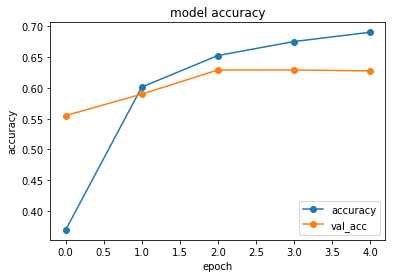

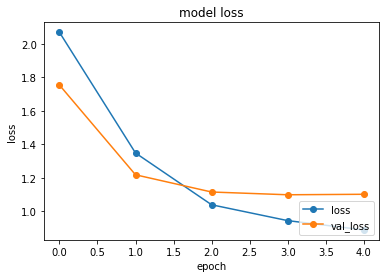

In [21]:
plot_history(history)

In [22]:
loss_and_metrics = model.evaluate(X_test,Y_test)
print("\nloss:{} accuracy:{}".format(loss_and_metrics[0],loss_and_metrics[1]))

736/736 [==============================] - 0s 58us/step

loss:1.1498537193173948 accuracy:0.6290760869565217
